# Importing libraries

In [1]:
import numpy as np
from numpy import newaxis
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

# Loading and splitting the dataset

In [2]:
#Loading the data
data = pd.read_excel(r'C:\Users\Admin\Downloads\Combined_Stocks.xlsx', date_parser = True)
data=data.dropna()
# Taking data from 2000 to 2020 as training set
data_training = data[data['Date']<'01-01-2020'].copy()
#0-3702

#test data
data_test = data[data['Date']>='01-01-2020'].copy()

# Data preprocessing of training data
training_data = data_training.drop(['Date'], axis=1)
testing_data = data_test.drop(['Date'], axis=1)

In [3]:
from keras.callbacks import EarlyStopping
earlyStop=EarlyStopping(monitor="val_loss",verbose=2,mode='min',patience=3)

Using TensorFlow backend.


# Using LSTM to predict stock prices

Train on 3489 samples, validate on 403 samples
Epoch 1/5
3489/3489 - 55s - loss: 0.0184 - accuracy: 5.7323e-04 - val_loss: 0.0141 - val_accuracy: 0.0000e+00
Epoch 2/5
3489/3489 - 52s - loss: 0.0028 - accuracy: 5.7323e-04 - val_loss: 0.0051 - val_accuracy: 0.0000e+00
Epoch 3/5
3489/3489 - 52s - loss: 0.0025 - accuracy: 5.7323e-04 - val_loss: 0.0053 - val_accuracy: 0.0000e+00
Epoch 4/5
3489/3489 - 54s - loss: 0.0022 - accuracy: 5.7323e-04 - val_loss: 0.0144 - val_accuracy: 0.0000e+00
Epoch 5/5
3489/3489 - 53s - loss: 0.0021 - accuracy: 5.7323e-04 - val_loss: 0.0560 - val_accuracy: 0.0000e+00
Epoch 00005: early stopping


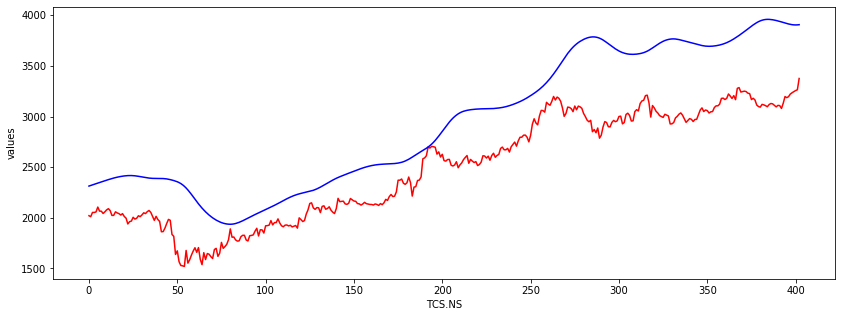

stock name= TCS.NS
55.962079763412476

Train on 3489 samples, validate on 403 samples
Epoch 1/5
3489/3489 - 56s - loss: 0.0166 - accuracy: 2.8662e-04 - val_loss: 0.0653 - val_accuracy: 0.0000e+00
Epoch 2/5
3489/3489 - 54s - loss: 0.0024 - accuracy: 2.8662e-04 - val_loss: 0.0364 - val_accuracy: 0.0000e+00
Epoch 3/5
3489/3489 - 53s - loss: 0.0026 - accuracy: 2.8662e-04 - val_loss: 0.0089 - val_accuracy: 0.0000e+00
Epoch 4/5
3489/3489 - 52s - loss: 0.0024 - accuracy: 2.8662e-04 - val_loss: 0.0243 - val_accuracy: 0.0000e+00
Epoch 5/5
3489/3489 - 52s - loss: 0.0021 - accuracy: 2.8662e-04 - val_loss: 0.0109 - val_accuracy: 0.0000e+00


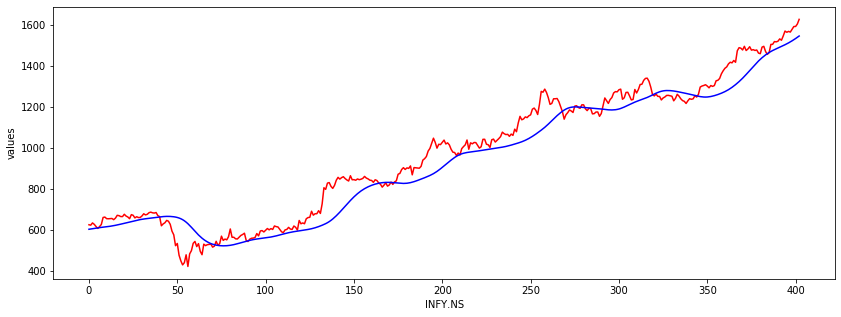

stock name= INFY.NS
80.00563979148865

Train on 3489 samples, validate on 403 samples
Epoch 1/5
3489/3489 - 57s - loss: 0.0237 - accuracy: 5.7323e-04 - val_loss: 0.0309 - val_accuracy: 0.0000e+00
Epoch 2/5
3489/3489 - 54s - loss: 0.0032 - accuracy: 5.7323e-04 - val_loss: 0.0197 - val_accuracy: 0.0000e+00
Epoch 3/5
3489/3489 - 53s - loss: 0.0030 - accuracy: 5.7323e-04 - val_loss: 0.0139 - val_accuracy: 0.0000e+00
Epoch 4/5
3489/3489 - 56s - loss: 0.0029 - accuracy: 5.7323e-04 - val_loss: 0.0283 - val_accuracy: 0.0000e+00
Epoch 5/5
3489/3489 - 55s - loss: 0.0027 - accuracy: 5.7323e-04 - val_loss: 0.0219 - val_accuracy: 0.0000e+00


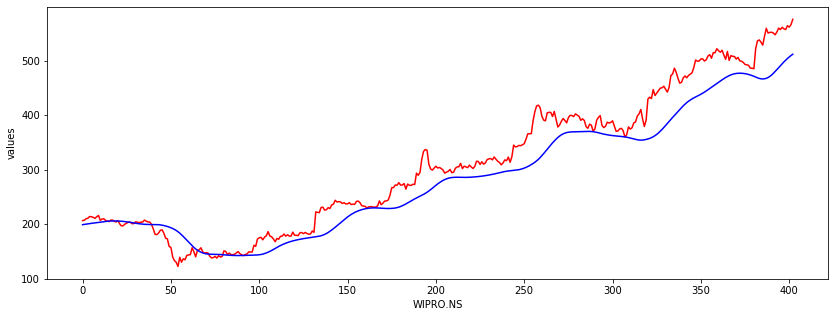

stock name= WIPRO.NS
112.15488910675049



In [4]:
for i in range(0,len(training_data.columns)):
    stock = training_data[training_data.columns[i]]
    stocks_train = stock.to_frame()
    stock_test = testing_data[testing_data.columns[i]]
    stocks_test = stock_test.to_frame()
    
    scaler = MinMaxScaler()
    stocks = scaler.fit_transform(stocks_train)
    
        
    X_train = []
    y_train = []
    for j in range(200, stocks.shape[0]):
        X_train.append(stocks[j-200:j])  
        y_train.append(stocks[j,0])
    
    X_train, y_train = np.array(X_train), np.array(y_train)

    past_200_days = stocks_train.tail(200)
    df = past_200_days.append(stocks_test, ignore_index=True)
    
    inputs = scaler.transform(df)

    X_test = []
    y_test = []
    
    for j in range(200, inputs.shape[0]):
        X_test.append(inputs[j-200:j])
        y_test.append(inputs[j,0])
    
    X_test, y_test  = np.array(X_test), np.array(y_test)
    
    model = Sequential()
    model.add(LSTM(units = 60, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1],1)))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 120, activation = 'relu'))
    model.add(Dropout(0.2))

    model.add(Dense(units = 1))
    #model.summary()

    model.compile(optimizer='adam', loss = 'mse', metrics = ['accuracy'])
    
    history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=5, batch_size=32, verbose=2, callbacks=[earlyStop])

    
    y_pred = model.predict(X_test)
    
    scale = 1/scaler.scale_[0]
    
    y_pred = y_pred*scale
    y_test = y_test*scale
    
    plt.figure(figsize=(14,5))
    plt.plot(y_test, color = 'red')
    plt.xlabel(data.columns[i+1])
    plt.ylabel("values")
    plt.plot(y_pred, color = 'blue')
    plt.show()
    
    
    first=np.mean(y_pred[150:180])
    last=np.mean(y_pred[373:403])
    percentage=(last-first)/first*100
    print("stock name= "+ data.columns[i+1] )
    print(percentage)
    print("")
    if(i==2):
        break


# Finding Correlation of the stocks

In [5]:
data.corr(method='pearson')

,TCS.NS,INFY.NS,WIPRO.NS,Dr Reddy,Lupin,Sun Pharma,TATA Steel,JSW Steel,Hindalco ind,MARUTI.NS,HEROMOTOCO.NS,TATAMOTORS.NS,HDFC.NSE,SBIN.NSE,ICICI.NSE
TCS.NS,1.000000,0.969346,0.939740,0.895404,0.601774,0.647382,0.576624,0.890762,0.702864,0.863947,0.821604,0.327279,0.952722,0.755237,0.956864
INFY.NS,0.969346,1.000000,0.968236,0.882189,0.546132,0.582263,0.654581,0.914698,0.738832,0.783494,0.750923,0.272652,0.904155,0.733021,0.939588
WIPRO.NS,0.939740,0.968236,1.000000,0.887084,0.608160,0.650098,0.702501,0.908247,0.776120,0.762233,0.773717,0.409137,0.868140,0.789700,0.928555
Dr Reddy,0.895404,0.882189,0.887084,1.000000,0.824294,0.836842,0.416035,0.719452,0.521206,0.734769,0.830733,0.561934,0.797875,0.730743,0.841989
Lupin,0.601774,0.546132,0.608160,0.824294,1.000000,0.973821,0.132787,0.404469,0.231831,0.599944,0.785065,0.831181,0.532348,0.631693,0.544766
Sun Pharma,0.647382,0.582263,0.650098,0.836842,0.973821,1.000000,0.199456,0.458928,0.286454,0.618738,0.799200,0.845957,0.568195,0.657208,0.591032
TATA Steel,0.576624,0.654581,0.702501,0.416035,0.132787,0.199456,1.000000,0.834612,0.915017,0.527117,0.455518,0.166386,0.610169,0.659932,0.665777
JSW Steel,0.890762,0.914698,0.908247,0.719452,0.404469,0.458928,0.834612,1.000000,0.876452,0.812853,0.721687,0.233136,0.891251,0.755932,0.893198
Hindalco ind,0.702864,0.738832,0.776120,0.521206,0.231831,0.286454,0.915017,0.876452,1.000000,0.687995,0.605508,0.251769,0.740711,0.730062,0.769725
MARUTI.NS,0.863947,0.783494,0.762233,0.734769,0.599944,0.618738,0.527117,0.812853,0.687995,1.000000,0.907972,0.406318,0.929280,0.750522,0.830435


# Choosing best stocks using correlation and annual returns 

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ffn
prices = ffn.get('sbin.ns,ICICIBANK.NS,HEROMOTOCO.NS,wipro.ns,jswsteel.ns,SUNPHARMA.NS,tatasteel.ns', start='2005-01-01')


#selected top stocks from that group on the basis of annual return if they were highly correlated
#WE WILL USE RETURNS FROM LSTM AND CORRELATION TO FIND STOCKS TO SELECT IN PORTFOLIO

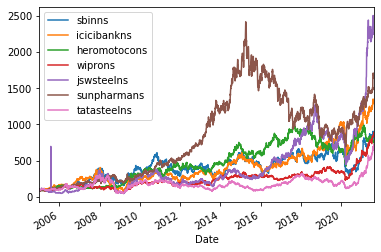

In [7]:
#plotting stock performace since 2015
ax = prices.rebase().plot()

In [8]:
np.seterr(all='ignore')
stats = prices.calc_stats()
stats.display()

Stat                 sbinns      icicibankns    heromotocons    wiprons     jswsteelns    sunpharmans    tatasteelns
-------------------  ----------  -------------  --------------  ----------  ------------  -------------  -------------
Start                2005-01-03  2005-01-03     2005-01-03      2005-01-03  2005-01-03    2005-01-03     2005-01-03
End                  2021-08-25  2021-08-25     2021-08-25      2021-08-25  2021-08-25    2021-08-25     2021-08-25
Risk-free rate       0.00%       0.00%          0.00%           0.00%       0.00%         0.00%          0.00%

Total Return         722.74%     1203.95%       639.83%         783.17%     2139.98%      1553.95%       556.89%
Daily Sharpe         0.53        0.59           0.55            0.58        0.35          0.70           0.48
Daily Sortino        0.93        1.02           0.97            0.98        2.29          1.19           0.82
CAGR                 13.50%      16.69%         12.78%          13.99%      20.54%     

In [9]:

# We put random weight in starting which will be optimized further
weights = np.asarray([0.2,0.2,0.1,0.1,0.1,0.1,0.2])

returns = prices.pct_change()
 
# mean daily return and covariance of daily returns
mean_daily_returns = returns.mean()
cov_matrix = returns.cov()

# portfolio return and volatility
pf_return = round(np.sum(mean_daily_returns * weights) * 252, 3)
pf_std_dev = round(np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252), 3)

print("Expected annualized return: " + "{:.1%}".format(pf_return))
print("Volatility: " + "{:.1%}".format(pf_std_dev))

Expected annualized return: 26.9%
Volatility: 36.1%


In [10]:
from pypfopt import expected_returns
from pypfopt import risk_models
from pypfopt import discrete_allocation
from pypfopt.cla import CLA

from pypfopt.efficient_frontier import EfficientFrontier

import matplotlib
from matplotlib.ticker import FuncFormatter

exp_returns = expected_returns.mean_historical_return(prices)
covar = risk_models.sample_cov(prices)

#have to use sortino here, hopefully that gives us better returns

# Optimise portfolio for maximum Sharpe Ratio
ef = EfficientFrontier(exp_returns, covar)
raw_weights = ef.max_sharpe()
pf = ef.clean_weights()
print(pf)
perf = ef.portfolio_performance(verbose=True)

OrderedDict([('sbinns', 0.03737), ('icicibankns', 0.10704), ('heromotocons', 0.19266), ('wiprons', 0.20425), ('jswsteelns', 0.00358), ('sunpharmans', 0.4551), ('tatasteelns', 0.0)])
Expected annual return: 16.4%
Annual volatility: 22.8%
Sharpe Ratio: 0.63


In [11]:
ef = EfficientFrontier(exp_returns, covar, weight_bounds=(-1, 1))
pf = ef.efficient_return(target_return=perf[0])
print(pf)
perf = ef.portfolio_performance(verbose=True)

OrderedDict([('sbinns', 0.0788218231896359), ('icicibankns', 0.1047458505058706), ('heromotocons', 0.2218450705976299), ('wiprons', 0.2317456554713331), ('jswsteelns', 0.0039558824940136), ('sunpharmans', 0.4340851308960028), ('tatasteelns', -0.0751994131544862)])
Expected annual return: 16.4%
Annual volatility: 22.6%
Sharpe Ratio: 0.64


In [ ]:

'''
now we can work on:

1. better stock prediction ie. fitting the graph properly
2. using sortino instead of sharpe
3. why does efficient frontier give lower return compared to random selected weights

'''